# Quadrature Mixers, IQ Demodulation, and the Tayloe Detector
- https://www.youtube.com/watch?v=JuuKF1RFvBM  
- http://www.analogzoo.com/2015/08/quadrature-mixers/  
- https://en.wikipedia.org/wiki/In-phase_and_quadrature_components 

In [1]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if len(target_path) * len(current_path) > 0:
            if target_path[0] == current_path[0]:
                target_path.pop(0)
                current_path.pop(0)
                del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [2]:
# paths = ['']
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [3]:
paths = [['..', '..', '..', '..', '..', 'Waves', 'bitbucket', 'github', 'codes'],
         ['..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [4]:
%pylab inline

# from waves.sound import *
from waves.tools.dsp.mixers.frequency_mixers import *

Populating the interactive namespace from numpy and matplotlib


In [5]:
import warnings 

warnings.filterwarnings('ignore')

In [6]:
def show_pair(sig_left, sig_right, frames = 300):
    sig_left.show(color = 'red', show_frames = slice(0, frames))
    sig_right.show(color = 'green', show_frames = slice(0, frames))

## LO

In [7]:
phase_shift = PI2 / 8

In [8]:
freq_lo = int(100e3)

freq_sampling = freq_lo * 8 * 2

In [9]:
duration_seconds = 1
t = np.linspace(0, duration_seconds, duration_seconds * freq_sampling)

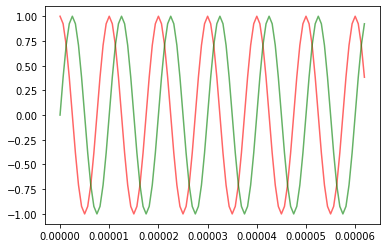

In [10]:
LO_I = Channel(np.cos(PI2 * freq_lo * t), ts = t, framerate = freq_sampling)
LO_Q = Channel(np.sin(PI2 * freq_lo * t), ts = t, framerate = freq_sampling) 

show_pair(LO_I, LO_Q, 100)

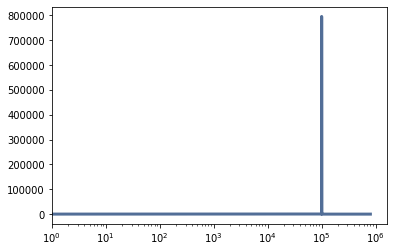

In [11]:
LO_I.make_spectrum().plot(freq_lims = (1, freq_sampling))

## IF

In [12]:
freq_if = 1000

IF_plus =  Channel(np.exp(1j * PI2 *   freq_if  * t), ts = t, framerate = freq_sampling)
IF_minus = Channel(np.exp(1j * PI2 * (-freq_if) * t), ts = t, framerate = freq_sampling)

# IF_plus =  Channel(np.exp(1j * (PI2 * freq_if * t + 0)), ts = t, framerate = freq_sampling)
# IF_minus = Channel(np.exp(1j * (PI2 * freq_if * t + phase_shift)), ts = t, framerate = freq_sampling)  # 有相位差

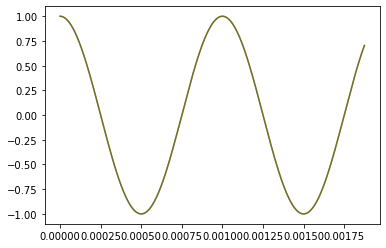

In [13]:
show_pair(IF_plus, IF_minus, 3000)

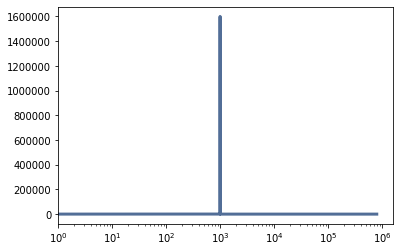

In [14]:
IF_plus.make_spectrum().plot(freq_lims = (1, freq_sampling))

## RF (Modulation)

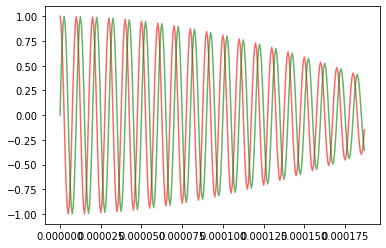

In [15]:
RF_plus_I = IF_plus * LO_I
RF_plus_Q = IF_plus * LO_Q
# RF_plus   = RF_plus_I + RF_plus_Q
RF_plus = Channel(RF_plus_I.ys + RF_plus_Q.ys, ts = t, framerate = freq_sampling) 

show_pair(RF_plus_I, RF_plus_Q, 300)

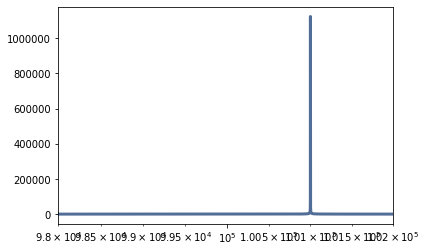

In [16]:
# RF_plus_I.make_spectrum().plot(freq_lims = (freq_lo - freq_if * 2 , freq_lo + freq_if * 2))
RF_plus.make_spectrum().plot(freq_lims = (freq_lo - freq_if * 2 , freq_lo + freq_if * 2))

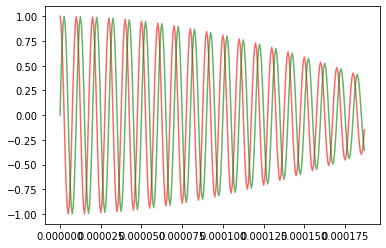

In [17]:
RF_minus_I = IF_minus * LO_I
RF_minus_Q = IF_minus * LO_Q
# RF_minus   = RF_minus_I + RF_minus_Q
RF_minus = Channel(RF_minus_I.ys + RF_minus_Q.ys, ts = t, framerate = freq_sampling) 

show_pair(RF_minus_I, RF_minus_Q, 300)

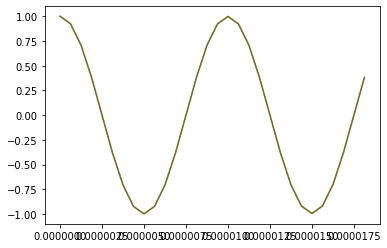

In [18]:
show_pair(RF_plus_I, RF_minus_I, 30)

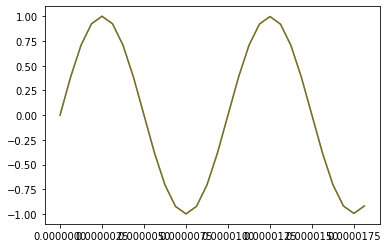

In [19]:
show_pair(RF_plus_Q, RF_minus_Q, 30)

## IF (De-modulation)

In [20]:
RF_plus =  Channel(np.exp(1j * PI2 * (freq_lo + freq_if) * t), ts = t, framerate = freq_sampling)
RF_minus = Channel(np.exp(1j * PI2 * (freq_lo - freq_if) * t), ts = t, framerate = freq_sampling)

### IF_plus

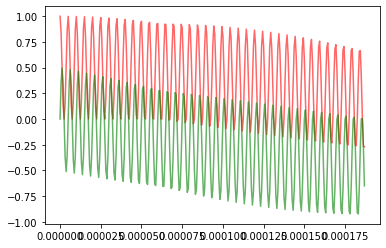

In [21]:
IF_plus_I_reconstructed = RF_plus * LO_I
IF_plus_Q_reconstructed = RF_plus * LO_Q 

show_pair(IF_plus_I_reconstructed, IF_plus_Q_reconstructed, 300)

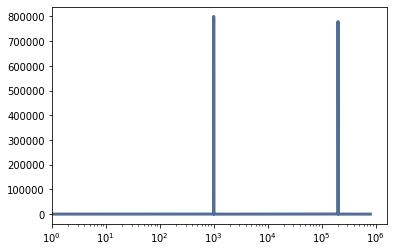

In [22]:
IF_plus_I_reconstructed.make_spectrum().plot(freq_lims = (1, freq_sampling))

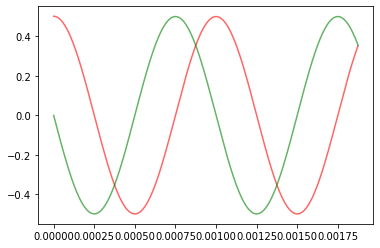

In [23]:
IF_plus_I_reconstructed = IF_plus_I_reconstructed.filter(low_pass_cutoff = freq_if * 2)
IF_plus_Q_reconstructed = IF_plus_Q_reconstructed.filter(low_pass_cutoff = freq_if * 2)

show_pair(IF_plus_I_reconstructed, IF_plus_Q_reconstructed, 3000)

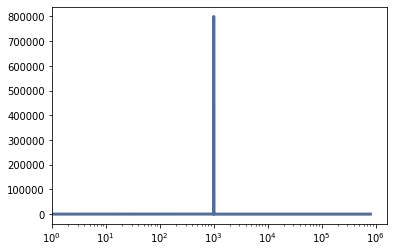

In [24]:
IF_plus_I_reconstructed.make_spectrum().plot(freq_lims = (1, freq_sampling))

### IF_minus

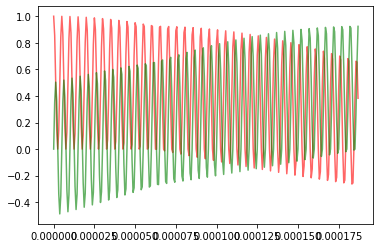

In [25]:
IF_minus_I_reconstructed = RF_minus * LO_I
IF_minus_Q_reconstructed = RF_minus * LO_Q 

show_pair(IF_minus_I_reconstructed, IF_minus_Q_reconstructed, 300)

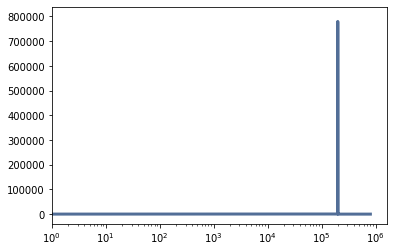

In [26]:
IF_minus_I_reconstructed.make_spectrum().plot(freq_lims = (1, freq_sampling))

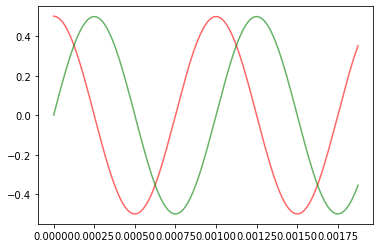

In [27]:
IF_minus_I_reconstructed = IF_minus_I_reconstructed.filter(low_pass_cutoff = freq_if * 2)
IF_minus_Q_reconstructed = IF_minus_Q_reconstructed.filter(low_pass_cutoff = freq_if * 2)

show_pair(IF_minus_I_reconstructed, IF_minus_Q_reconstructed, 3000)

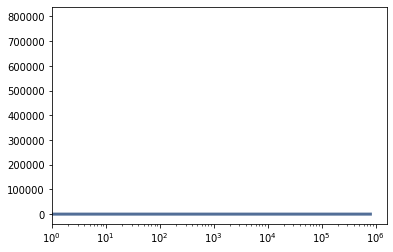

In [28]:
IF_minus_I_reconstructed.make_spectrum().plot(freq_lims = (1, freq_sampling))

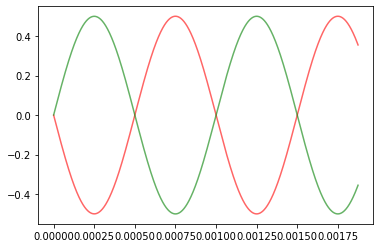

In [29]:
show_pair(IF_plus_Q_reconstructed, IF_minus_Q_reconstructed, 3000)

## 使用同一個 freq 但是有 phase shift

In [30]:
cycle_lag_ratio = phase_shift / PI2
samples_per_cycle = freq_sampling / freq_lo 
lags = int(cycle_lag_ratio * samples_per_cycle)
lags

2

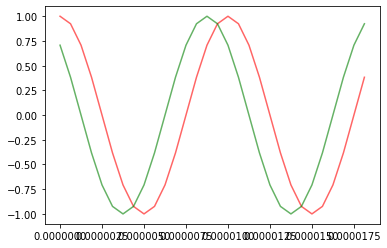

In [31]:
signal_1 = Channel(np.exp(1j * (PI2 * freq_lo * t + 0)), ts = t, framerate = freq_sampling)
signal_2 = Channel(np.exp(1j * (PI2 * freq_lo * t + phase_shift)), ts = t, framerate = freq_sampling)  # 有相位差 

show_pair(signal_1, signal_2, 30)

### Note:
- 雖然 signal_1, signal_2 看起來都一樣，但其實有相位差
- 分別呈上 cos, sin 做 modulation，就可以看出 差別

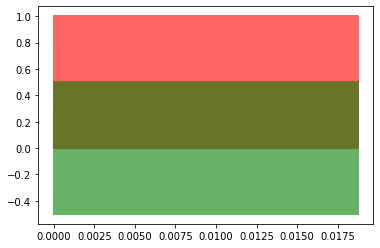

In [32]:
signal_1_I = signal_1 * LO_I 
signal_1_Q = signal_1 * LO_Q

show_pair(signal_1_I, signal_1_Q, 30000)

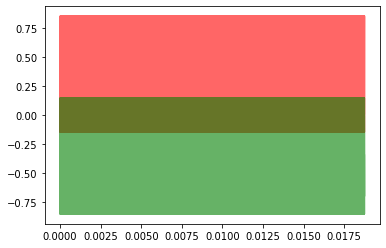

In [33]:
signal_2_I = signal_2 * LO_I 
signal_2_Q = signal_2 * LO_Q 

show_pair(signal_2_I, signal_2_Q, 30000)

### 但是這只是有限 time window 所造成的假象
- window 移動的話，結果也會變化

In [34]:
signal_2 = Channel(np.hstack([signal_2.ys[-lags:], signal_2.ys[:-lags]]), ts = t, framerate = freq_sampling)

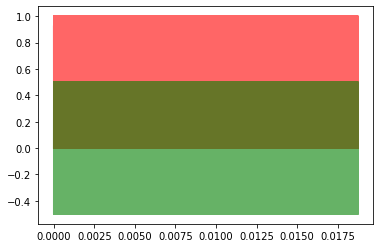

In [35]:
signal_2_I = signal_2 * LO_I 
signal_2_Q = signal_2 * LO_Q

show_pair(signal_2_I, signal_2_Q, 30000)

In [36]:
# plt.plot(t, signal_1_I.ys - signal_2_I.ys);

In [37]:
# plt.plot(t, signal_1_Q.ys - signal_2_Q.ys);